In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
import click 
import umap
import os

2023-12-09 20:57:37.814552: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/DAVIDSON/dmkurdydyk/.conda/envs/aot/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# May need removal or adjustment for the needed file paths with base_dir

# Base directory
base_dir = os.getcwd()

# Paths
data_raw_where = base_dir + '/data/' # where the raw data(before sampling) were stored
data_sampled_where = base_dir + '/data/data_sampled' # where the sampled data were stored
weights_path = base_dir + '/new_weights/' # where the weights were stored
predict_where = base_dir + '/new_one_class_SVM_predict/' # Where to save predictions
umap_where = base_dir + '/umap_plots/' # where to save umap plots

# Constants
ISOTOPE = 'O16'
folder = base_dir + '/datalessthan5/'
sample_size = 512 # sample size = num_points 
d_max = 1024 # Size of latent Space

In [9]:
from tensorflow import keras
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)
    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))
    def get_config(self):
        return {'l2reg': self.l2reg, 'num_features': self.num_features}

# Now load the model
model_path = 'FRIB_Distant_Transfer/new_model_saves'
loaded_model = keras.models.load_model(model_path, custom_objects={'OrthogonalRegularizer': OrthogonalRegularizer})

num_classes = 3

# Get the output of the second-to-last layer
second_to_last_layer_output = loaded_model.layers[-2].output

# Create a new output layer with a unique name
new_output = Dense(num_classes, activation='softmax', name='multi_class_O16')(second_to_last_layer_output)

# Create a new model with the same inputs as the loaded model and the new output layer
model = Model(inputs=loaded_model.input, outputs=new_output)

batch_size = 32
learning_rate = 0.001

data_array = np.load('FRIB_Distant_Transfer/O16_expt/ready/distant_O16_expt_data_512.npy')
labels_array = to_categorical(np.load('FRIB_Distant_Transfer/O16_expt/ready/distant_O16_expt_labels_512.npy')) 

train_data, test_data, train_labels, test_labels = train_test_split(data_array, labels_array, test_size=0.2, random_state=42)

# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Create TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(batch_size, drop_remainder=True)
val_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(batch_size, drop_remainder=True)

Epoch 1/5
45/45 [==============================] - 60s 1s/step - loss: 2.7752 - accuracy: 0.7188 - val_loss: 2.8390 - val_accuracy: 0.6761
Epoch 2/5
45/45 [==============================] - 60s 1s/step - loss: 2.7300 - accuracy: 0.7556 - val_loss: 2.8119 - val_accuracy: 0.7216
Epoch 3/5
45/45 [==============================] - 60s 1s/step - loss: 2.6882 - accuracy: 0.7799 - val_loss: 2.7875 - val_accuracy: 0.7443
Epoch 4/5
45/45 [==============================] - 60s 1s/step - loss: 2.6655 - accuracy: 0.8007 - val_loss: 2.7899 - val_accuracy: 0.7301
Epoch 5/5
45/45 [==============================] - 60s 1s/step - loss: 2.6341 - accuracy: 0.8014 - val_loss: 2.8228 - val_accuracy: 0.7301


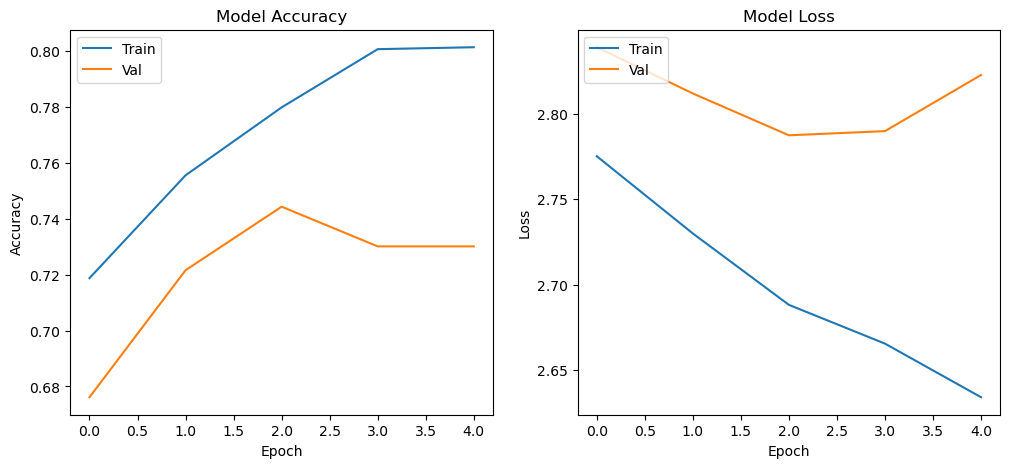

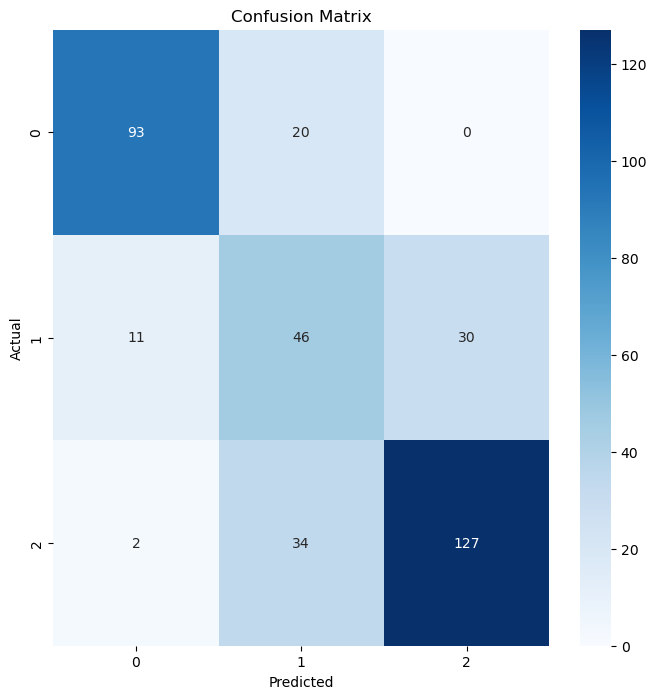

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Train the model and save the history
history = model.fit(train_ds, epochs=5, validation_data=val_ds)

# Plotting and saving the learning curve
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig('FRIB_Distant_Transfer/O16_expt/data/results/plots/learning_curve.png')

# Predict the labels on the test set
test_predictions = model.predict(test_data)
test_predictions = np.argmax(test_predictions, axis=1)

cm = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

plt.savefig('FRIB_Distant_Transfer/O16_expt/data/results/plots/confusion_matrix.png')